# Vehicle Silhouette Detection using Support Vector Machine (SVM) and Principal Component Analysis (PCA)

## Data Description:
The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

## Domain:
Object recognition

## Context:
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

## Objective:
Apply the dimensionality reduction technique – PCA and train a model using principal components instead of training the model using just the raw data.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn import metrics
import math

In [2]:
# read data into a dataframe
vehicle_main_df = pd.read_csv("vehicle.csv")
vehicle_main_df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [3]:
# see the general information about dataset like, shape, datatype, missing values etc.
vehicle_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

#### Observation :
-   Datatypes vary amongst int64, float64 and object. Need to make them uniform (all int64) for further data processing and model training.
-   Our target column ("class") is a categorical variable and needs to be converted into a numerical column by assigning each category an integer value.
-   Some columns' total count does not match total entries of the dataframe like circularity, distance_circularity etc. Need to analyse such columns further to detect any missing or unknown values and accordingly deal with them before visualisation step.


In [4]:
# see if the dataframe has any duplicate entries
print(vehicle_main_df[vehicle_main_df.duplicated()])

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []


#### Observation :
-   This means given dataset does not have any duplicate data which we need to take care of before further analysis.

In [5]:
# convert target column from object datatype into integer datatype
vehicle_main_df["class"] = vehicle_main_df["class"].astype("category")
vehicle_main_df["class"] = vehicle_main_df["class"].cat.codes
vehicle_main_df["class"] = vehicle_main_df["class"].astype("int64")
print(vehicle_main_df["class"].unique()[::-1])
print(vehicle_main_df.dtypes)

[0 1 2]
compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                            int64
dtype: object


#### Note :
- 0 means bus
- 1 means car
- 2 means van

In [6]:
# check missing/unknown values in the dataset
vehicle_main_df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

#### Observation :
-   Columns **radius_ratio** and **skewness_about** have the maximum number of missing values.

In [7]:
# replace missing values in each column with the median value of that column and make the datatype as int64 wherever necessary
for cols in vehicle_main_df.columns:
    if (vehicle_main_df[cols].dtypes == np.float64):
        vehicle_main_df[cols] = vehicle_main_df[cols].fillna(vehicle_main_df[cols].median())
        vehicle_main_df[cols] = vehicle_main_df[cols].astype('int64')
    if (vehicle_main_df[cols].dtypes == np.int64 and cols != "class"):
        vehicle_main_df[cols] = vehicle_main_df[cols].fillna(vehicle_main_df[cols].median())

In [8]:
vehicle_main_df.isna().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [9]:
vehicle_main_df.dtypes

compactness                    int64
circularity                    int64
distance_circularity           int64
radius_ratio                   int64
pr.axis_aspect_ratio           int64
max.length_aspect_ratio        int64
scatter_ratio                  int64
elongatedness                  int64
pr.axis_rectangularity         int64
max.length_rectangularity      int64
scaled_variance                int64
scaled_variance.1              int64
scaled_radius_of_gyration      int64
scaled_radius_of_gyration.1    int64
skewness_about                 int64
skewness_about.1               int64
skewness_about.2               int64
hollows_ratio                  int64
class                          int64
dtype: object

In [10]:
# see the 5-point summary of the dataset to detect any outliers
vehicle_main_df_statistics = vehicle_main_df.describe().round(2).T
vehicle_main_df_statistics["Mean:Median"] = (vehicle_main_df_statistics["mean"]/vehicle_main_df_statistics["50%"]).round(2)
vehicle_main_df_statistics

,count,mean,std,min,25%,50%,75%,max,Mean:Median
compactness,846.0,93.68,8.23,73.0,87.00,93.0,100.00,119.0,1.01
circularity,846.0,44.82,6.13,33.0,40.00,44.0,49.00,59.0,1.02
distance_circularity,846.0,82.10,15.74,40.0,70.00,80.0,98.00,112.0,1.03
radius_ratio,846.0,168.87,33.40,104.0,141.00,167.0,195.00,333.0,1.01
pr.axis_aspect_ratio,846.0,61.68,7.88,47.0,57.00,61.0,65.00,138.0,1.01
max.length_aspect_ratio,846.0,8.57,4.60,2.0,7.00,8.0,10.00,55.0,1.07
scatter_ratio,846.0,168.89,33.20,112.0,147.00,157.0,198.00,265.0,1.08
elongatedness,846.0,40.94,7.81,26.0,33.00,43.0,46.00,61.0,0.95
pr.axis_rectangularity,846.0,20.58,2.59,17.0,19.00,20.0,23.00,29.0,1.03
max.length_rectangularity,846.0,148.00,14.52,118.0,137.00,146.0,159.00,188.0,1.01


#### Observation :
-   Columns like **radius_ratio**, **pr.axis_aspect_ratio**, **max.length_aspect_ratio**, **scaled_variance**, **scaled_variance.1**, **scaled_radius_of_gyration.1** and **skewness_about** have huge difference between their respective "max" values and "upper quartile" values. Hence, these columns are most likely to have outliers. Need to confirm the same using visual techniques like BoxPlots and DistPlots, and deal with the outliers accordingly.

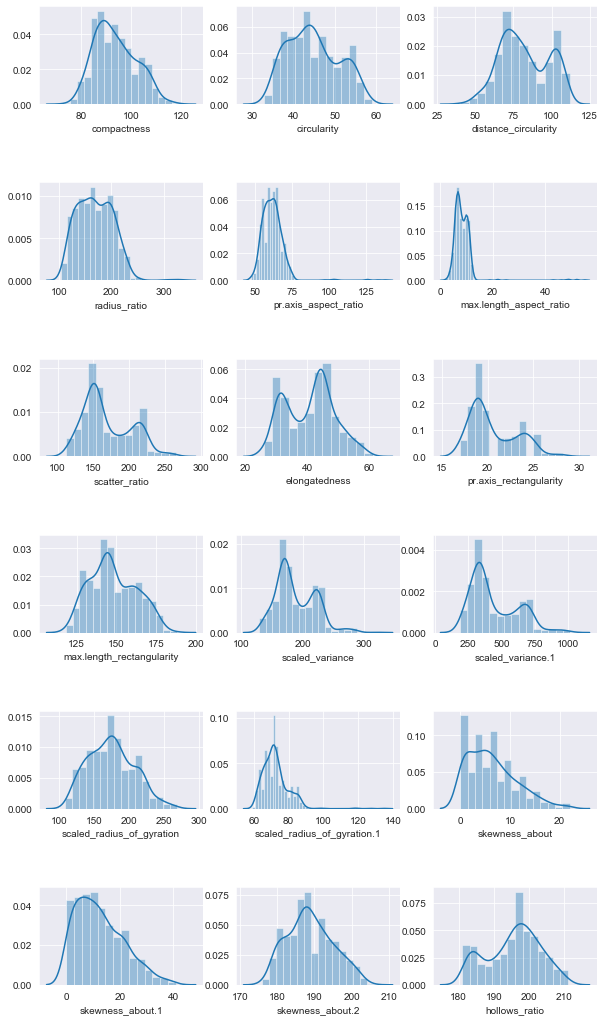

In [11]:
# study outliers using DistPlots
# Function to print DistPlots for the columns of the dataset
def showDistPlot (rows,cols,df):
    ## set the subplots count
    figsize_x = 30/cols
    figsize_y = 18
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(figsize_x,figsize_y))
    plt.subplots_adjust(hspace=0.8, wspace=0.2)
    ## loop through the data frame columns
    for cols,ax in zip(df.columns,axes.flat):
        sns.distplot(df[cols], hist=True, ax=ax)
        ax.set(xlabel=cols)
        
showDistPlot (6,3,vehicle_main_df.iloc[:, :-1]) # excluding target column to focus on the distribution of independent variables only

#### Observation :
-   Majority of the columns are not unimodal which suggests that the dataset could have more than one clusters.
-   Columns of the dataset are spread across different scales. Hence, we will have to standardise the data before training the model.
-   Columns like **skewness_about** and **skewness_about.1** are right skewed, while **skewness_about.2** is nearly normally distributed.
-   Columns like **radius_ratio**, **pr.axis_aspect_ratio**, **max.length_aspect_ratio**, **scaled_variance**, **scaled_variance.1**, **scaled_radius_of_gyration.1** and **skewness_about** have a long right tail, which suggests that these columns will have outliers.

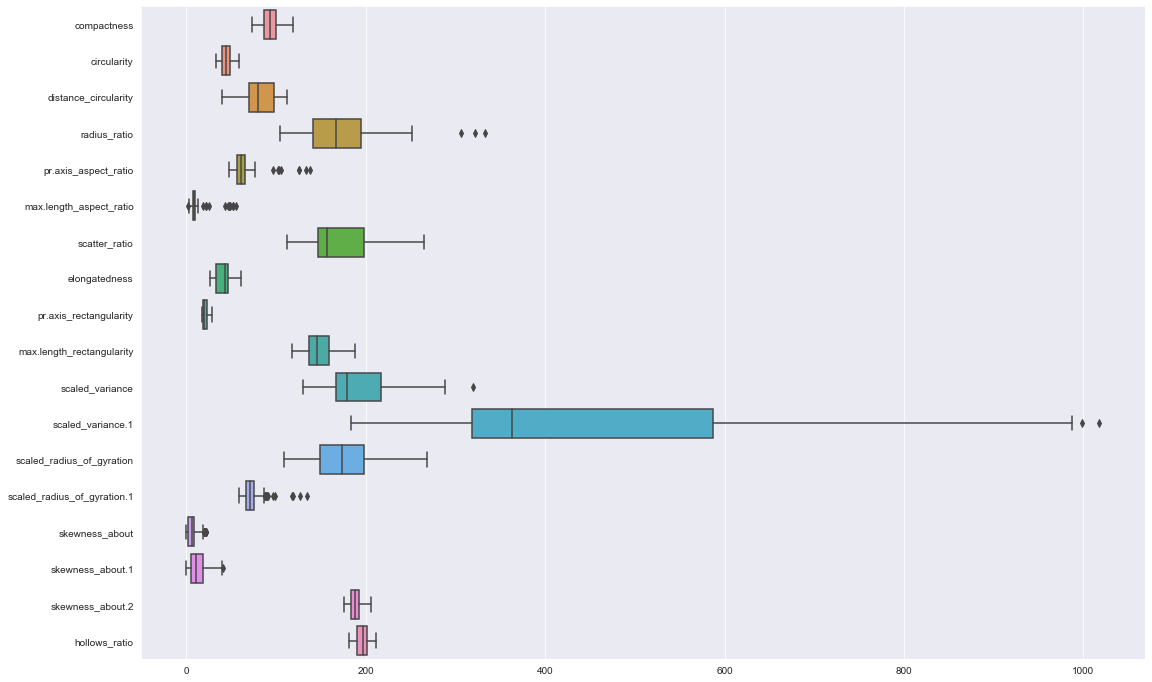

In [12]:
# study outliers using BoxPlots
figsize_x = 18
figsize_y = 12
f,ax = plt.subplots(figsize=(figsize_x,figsize_y))
sns.boxplot(data=vehicle_main_df.iloc[:, :-1], orient="h", ax =ax) # excluding target column to focus on the distribution of independent variables only
plt.show();

#### Observation :
-   Columns like **radius_ratio**, **pr.axis_aspect_ratio**, **max.length_aspect_ratio**, **scaled_variance**, **scaled_variance.1**, **scaled_radius_of_gyration.1** and **skewness_about** have data points beyond the whiskers of their respective box plots, which suggests that these columns will have outliers.

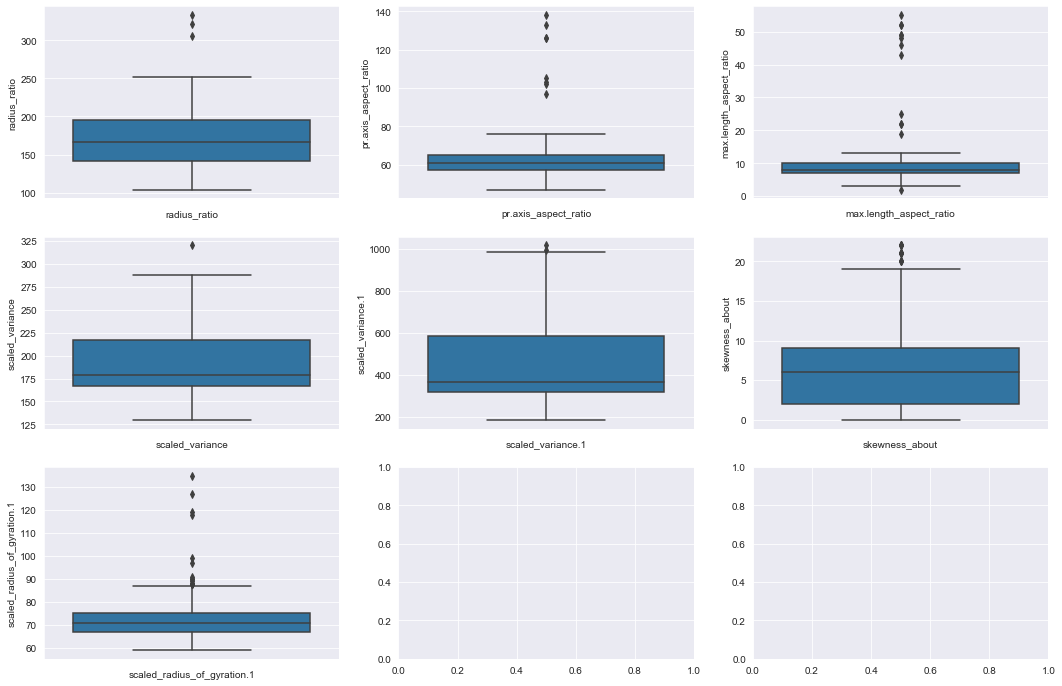

In [13]:
# study the outliers confirmed so far in further detail
# Function to show Boxplot of all the columns that can have outliers as per earlier observations
def studyOutliersInDetail (columns,df):
    rows = math.ceil(len(columns)/3)
    figsize_x = 18
    figsize_y = 12
    fig, axes = plt.subplots(ncols=3, nrows=rows, figsize=(figsize_x,figsize_y))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    ## loop through the data frame columns
    for cols,ax in zip(columns,axes.flat):
        sns.boxplot(y=cols, data=df, ax=ax)
        ax.set(xlabel=cols)
    plt.show();

columns = ["radius_ratio","pr.axis_aspect_ratio","max.length_aspect_ratio", "scaled_variance", "scaled_variance.1",
           "skewness_about","scaled_radius_of_gyration.1"]
studyOutliersInDetail(columns,vehicle_main_df)

#### Observation :
-   Columns **max.length_aspect_ratio** and **scaled_radius_of_gyration.1** have the highest number of outliers in all the columns of the dataset.

In [14]:
# count the number of outliers and find its ratio against total number of records to determine the importance of these outliers
outlier_count = 0
outlier_count += vehicle_main_df["radius_ratio"][vehicle_main_df["radius_ratio"] > 250].count()
outlier_count += vehicle_main_df["pr.axis_aspect_ratio"][vehicle_main_df["pr.axis_aspect_ratio"] > 80].count()
outlier_count += vehicle_main_df["max.length_aspect_ratio"][vehicle_main_df["max.length_aspect_ratio"] > 18].count()
outlier_count += vehicle_main_df["scaled_radius_of_gyration.1"][vehicle_main_df["scaled_radius_of_gyration.1"] > 87].count()
outlier_count += vehicle_main_df["scaled_variance.1"][vehicle_main_df["scaled_variance.1"] > 950].count()
outlier_count += vehicle_main_df["scaled_variance"][vehicle_main_df["scaled_variance"] > 287].count()
outlier_count += vehicle_main_df["skewness_about"][vehicle_main_df["skewness_about"] > 18].count()
print("There are total {count} outliers in the current dataset,".format(count = outlier_count))
print("...which makes up about {percentage:.2f}% of the total records present the dataset.".format(percentage = ((outlier_count/vehicle_main_df.shape[0])*100)))

There are total 66 outliers in the current dataset,
...which makes up about 7.80% of the total records present the dataset.


#### Observation :
-   Since the ratio of outliers to the total number of records in the dataset is very low, these records can be safely ignored from the dataset for model training.

In [15]:
# remove the outliers
vehicle_main_df = vehicle_main_df[vehicle_main_df["radius_ratio"] < 250]
vehicle_main_df = vehicle_main_df[vehicle_main_df["pr.axis_aspect_ratio"] < 80]
vehicle_main_df = vehicle_main_df[vehicle_main_df["max.length_aspect_ratio"] < 18]
vehicle_main_df = vehicle_main_df[vehicle_main_df["scaled_radius_of_gyration.1"] <87]
vehicle_main_df = vehicle_main_df[vehicle_main_df["scaled_variance.1"] < 950]
vehicle_main_df = vehicle_main_df[vehicle_main_df["scaled_variance"] < 287]
vehicle_main_df = vehicle_main_df[vehicle_main_df["skewness_about"] < 18]
vehicle_main_df = vehicle_main_df.reset_index(drop=True)
vehicle_main_df.shape

(787, 19)

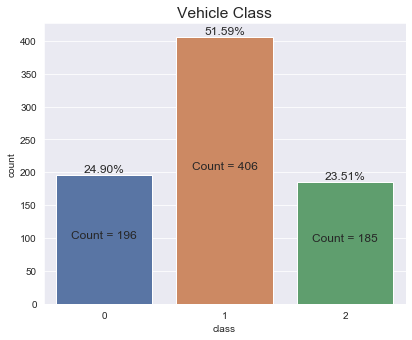

In [16]:
#univariate analysis
# check distribution of Class column to determine whether the target variable is balanced or imbalanced
plt.subplots(figsize = (6,5))
sns.set(font_scale=1.3)
ax = sns.countplot(x = "class", data=vehicle_main_df)
ax.set_title("Vehicle Class")
total = len(vehicle_main_df) # for calculation of percentage

for p in ax.patches:
    #get Height of the column
    height = p.get_height()
    X = p.get_x() + p.get_width()/2
    Y = height + 4
    ax.text(X, Y, '{:1.2f}%'.format((height/total)*100), ha="center", size=12)
    ax.text(X, Y/2, f'Count = {height}', ha="center", size=12)
    plt.tight_layout()
    
plt.show(); #semicolon is used to suppress all the matplotlib text outputs.

#### Observations :
-   0 means bus; 1 means car; 2 means van
-   Class type 'car' is the dominant category with 51% share, while the other two Class types 'bus' and 'van' comprise of the remaining 49% share.

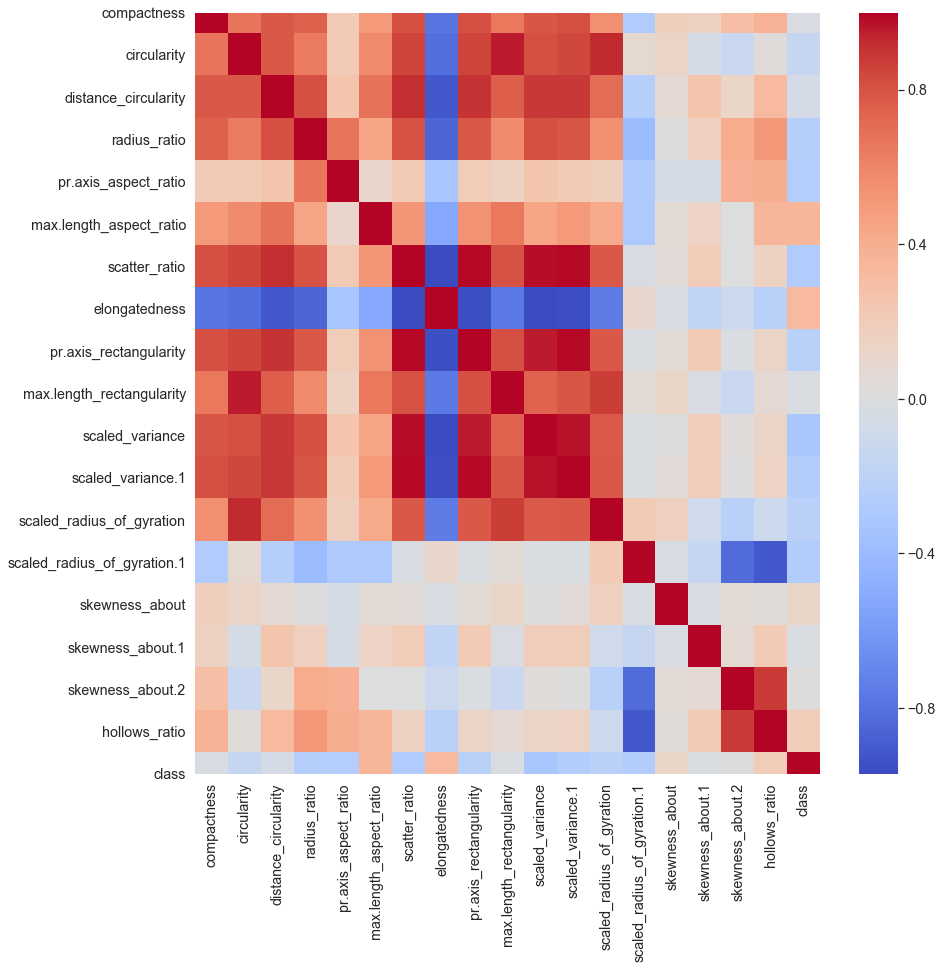

In [17]:
# multivariate analysis using heat map
vehicle_main_df_corr = vehicle_main_df.corr().round(2)
f,ax=plt.subplots(figsize=(14,14))
sns.heatmap(vehicle_main_df_corr, 
        xticklabels=vehicle_main_df_corr.columns,
        yticklabels=vehicle_main_df_corr.columns,cmap='coolwarm',ax =ax)

#### Observations :
-   Columns **compactness**, **circularity**, **distance_circularity**, **radius_ratio**, **scatter_ratio**, **elongatedness**, **pr.axis_rectangularity**, **max.length_rectangularity**, **scaled_variance**, **scaled_variance.1**, **scaled_radius_of_gyration**, **class** have high correlation amongst themselves, which make them a potential candidate for PCA dimentionality reduction technique.
-   Columns **pr.axis_aspect_ratio** and **max.length_aspect_ratio** have little to no correlation with any other column of the dataset.
-   Column **scaled_radius_of_gyration.1** has high negative correaltion with **skewness_about.2** and **hollows_ratio** columns, while it has very less correlation with other columns of the dataset.
-   Column **hollows_ratio** has a high positive correlation with **skewness_about.2** and a high negative correlation with  **scaled_radius_of_gyration.1** column.

In [18]:
# multivariate analysis using pair plot
# Since there are in total 19 columns in the dataset, it would be better for the sake of clarity to visualise the pair plot of the entire dataset in two parts
# We are segregating the columns based on the correlation pattern that we derived in above Heat Map

vehicle_main_df_part1 = vehicle_main_df[['compactness', 'circularity', 'distance_circularity', 'radius_ratio', 
                                         'scatter_ratio', 'elongatedness', 'pr.axis_rectangularity', 
                                         'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1', 
                                         'scaled_radius_of_gyration','class']]

vehicle_main_df_part2 = vehicle_main_df[['pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_radius_of_gyration.1', 
                                         'skewness_about', 'skewness_about.1', 'skewness_about.2', 'hollows_ratio', 'class']]

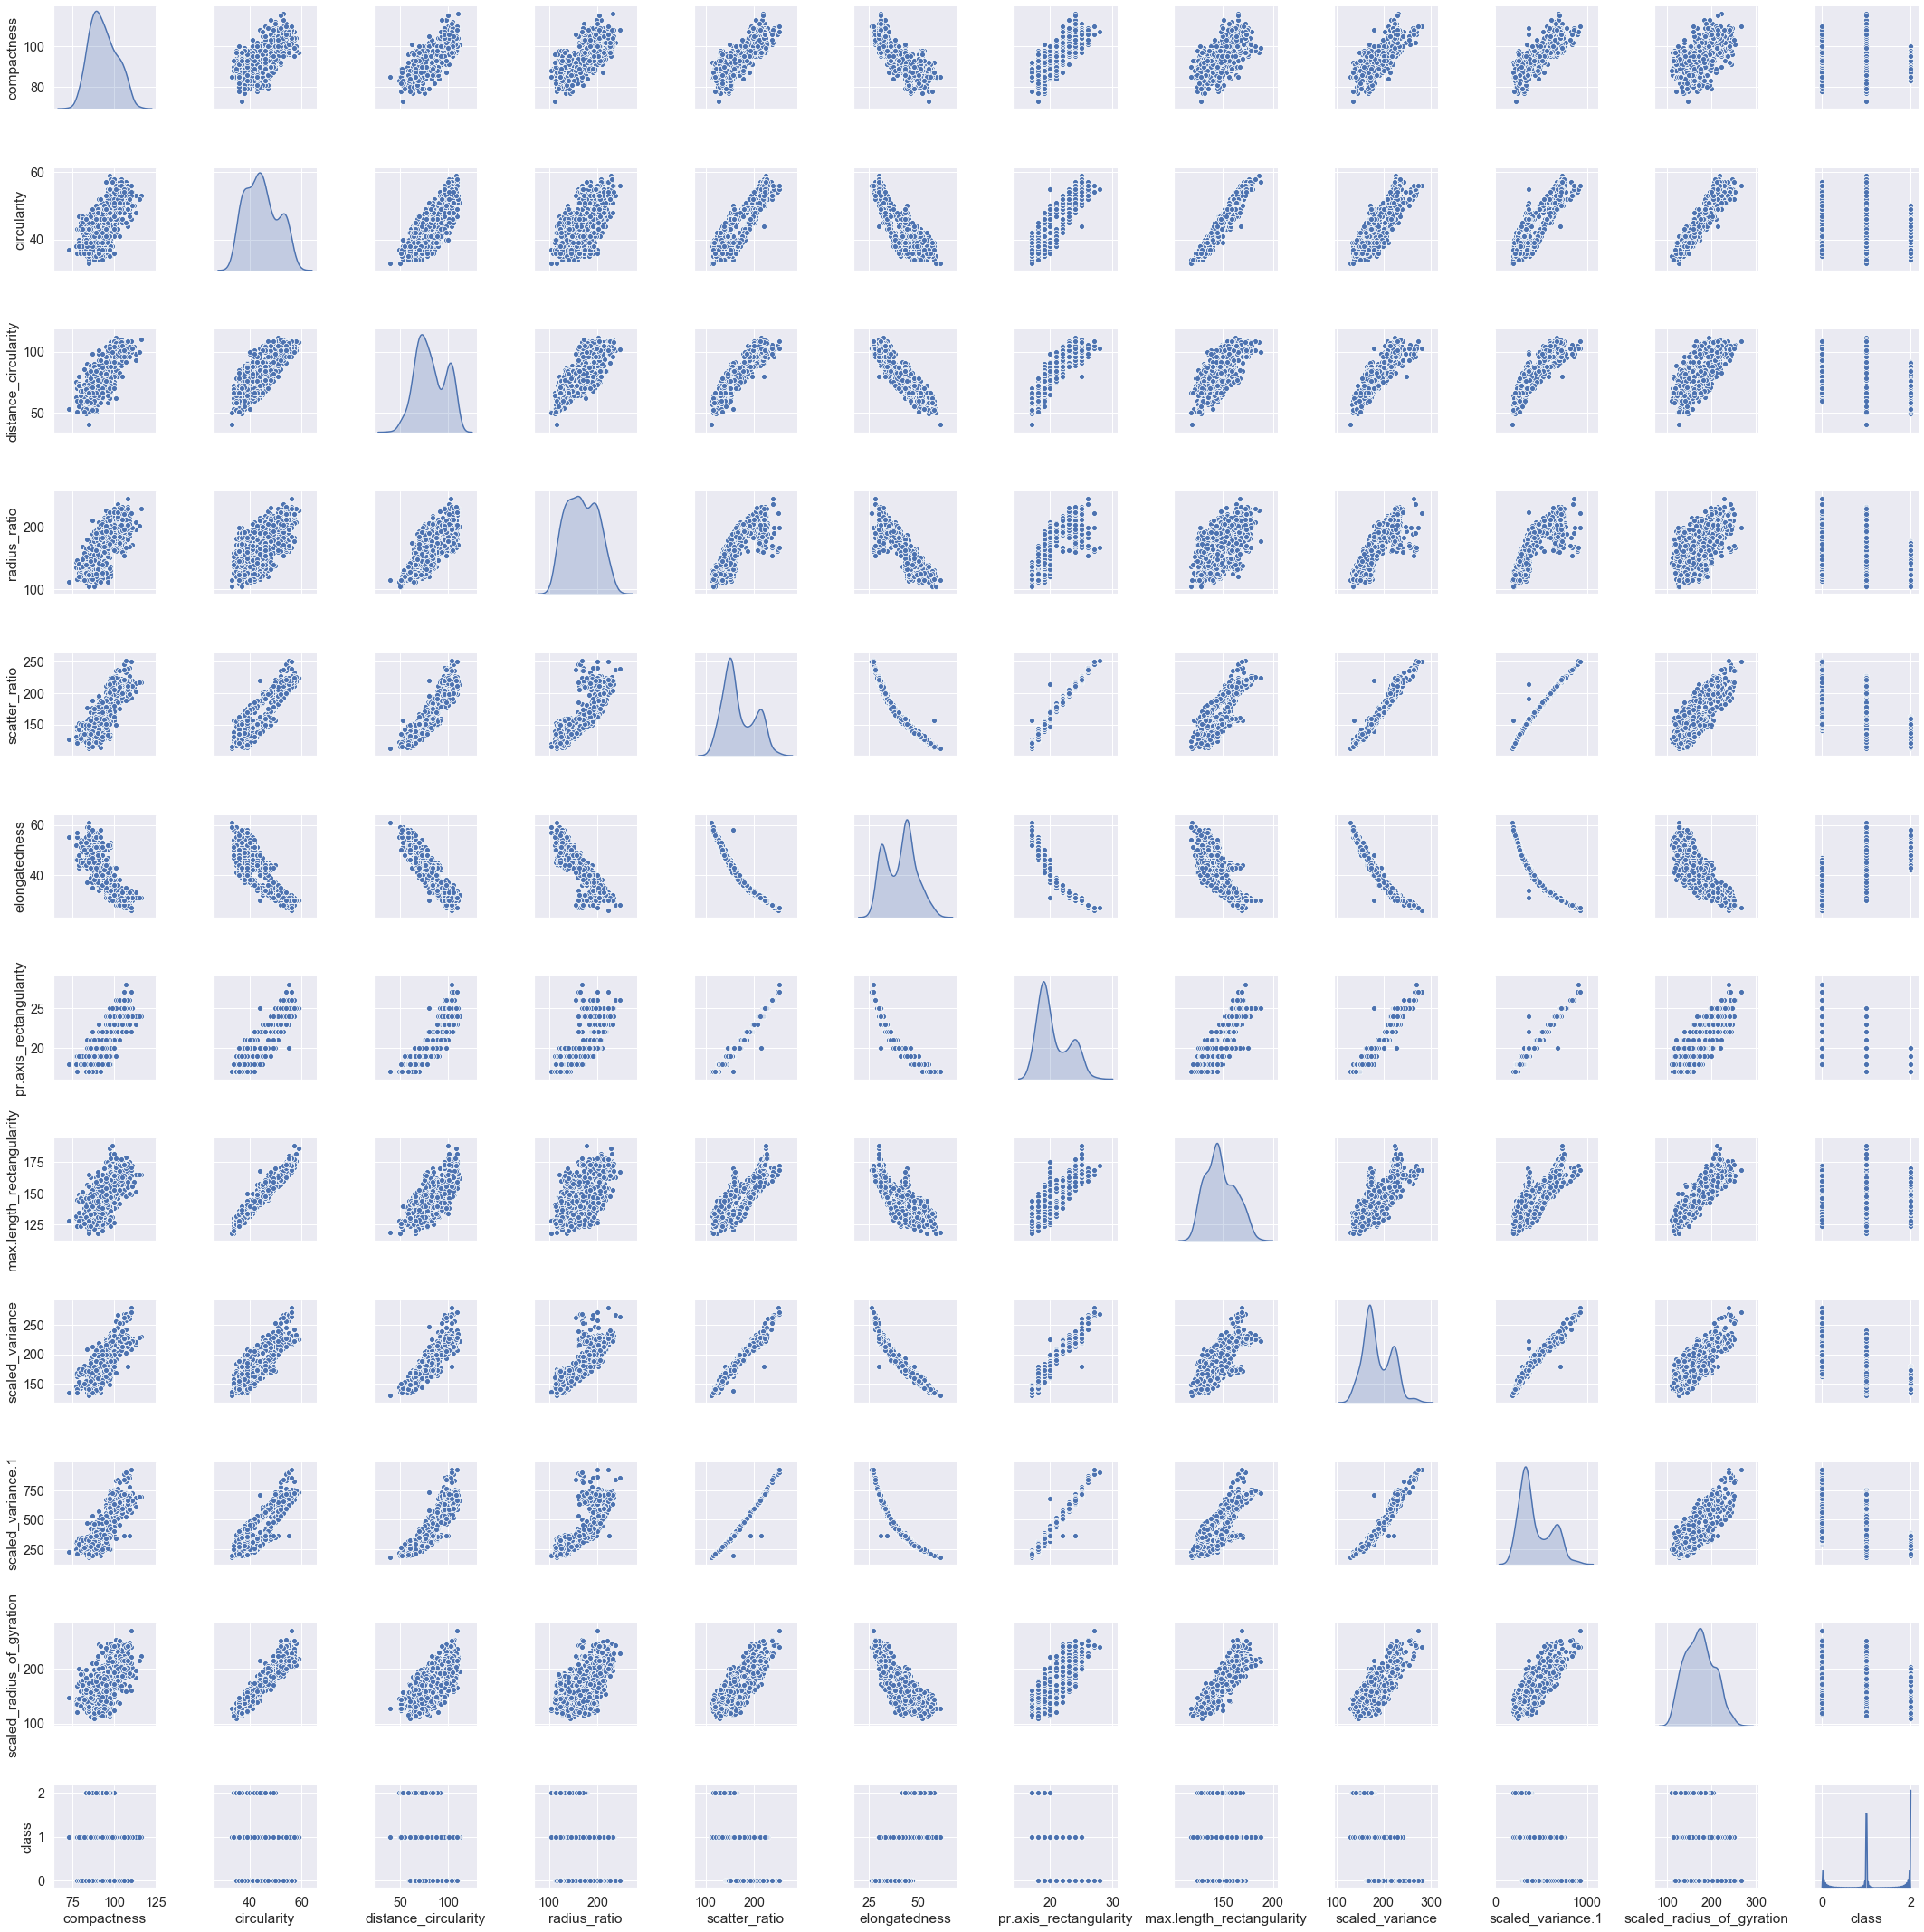

In [19]:
sns.pairplot(data = vehicle_main_df_part1, diag_kind="kde")

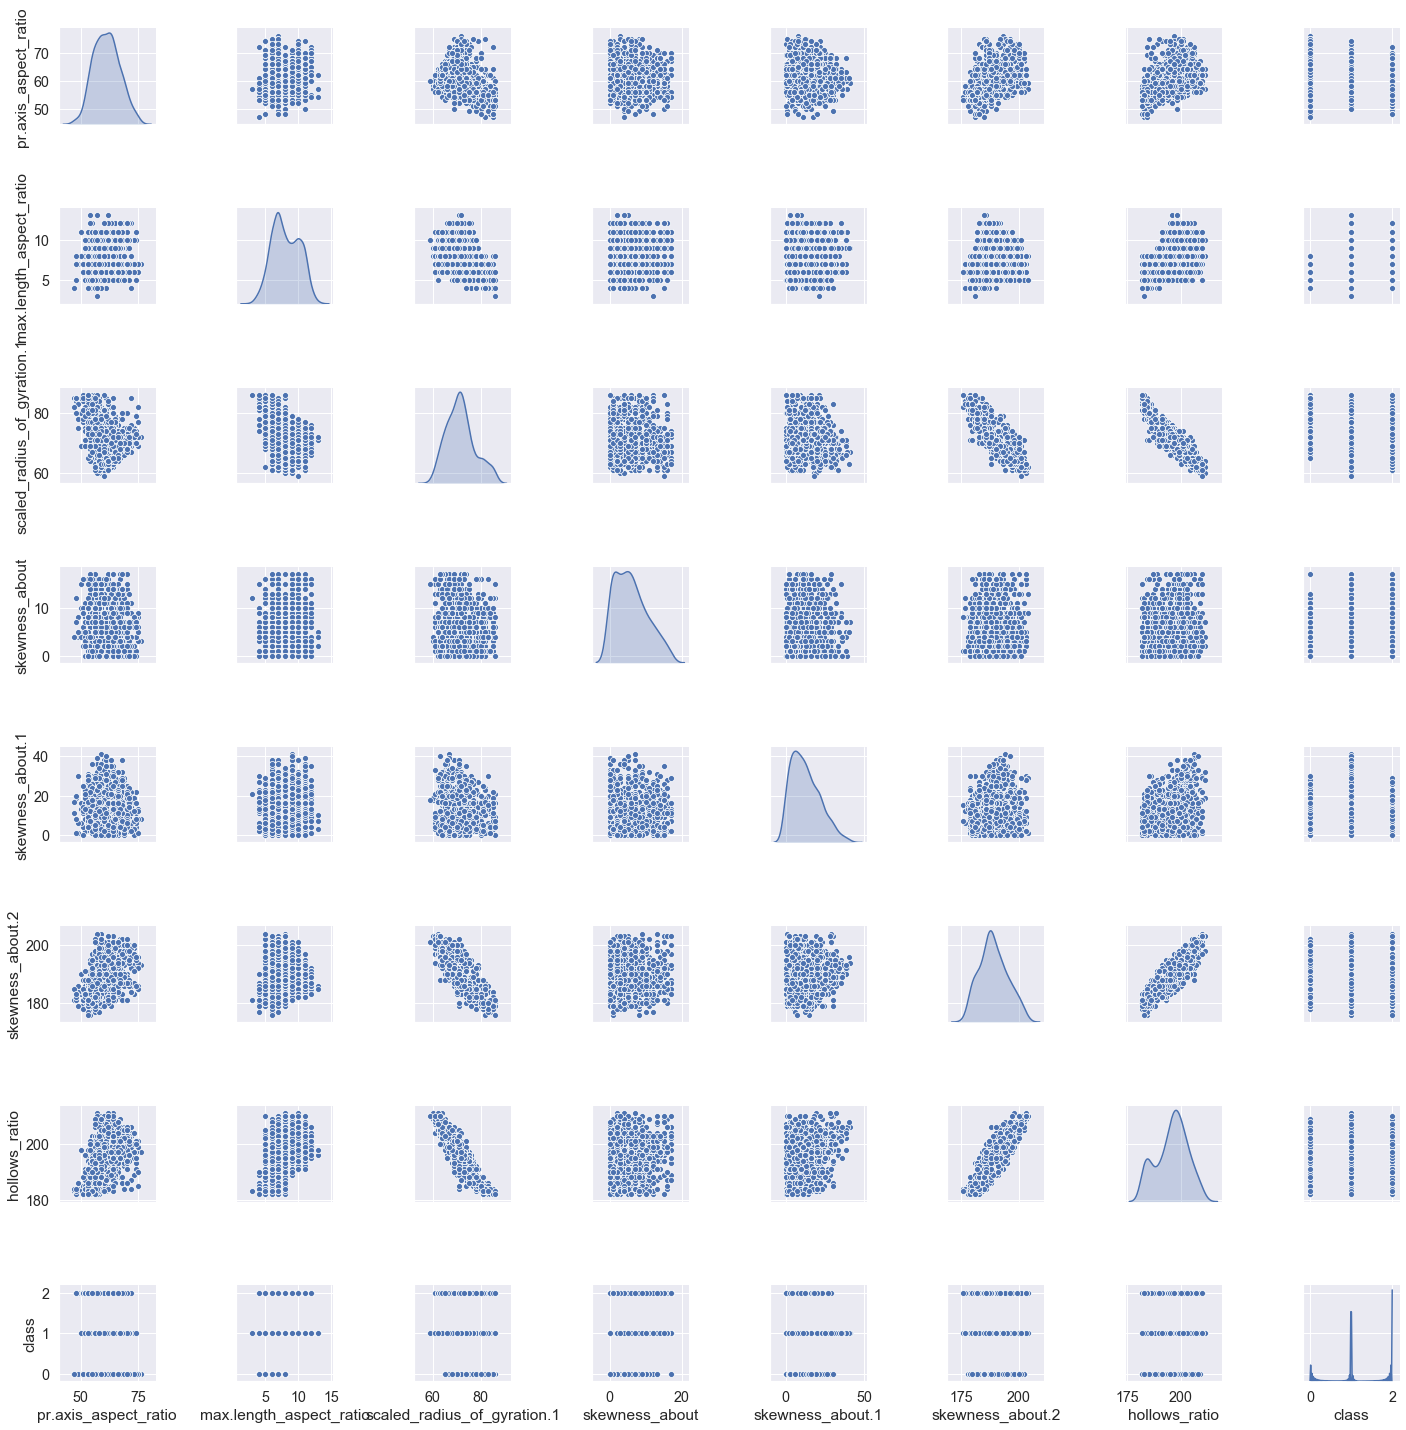

In [20]:
sns.pairplot(data = vehicle_main_df_part2, diag_kind="kde")

#### Observations :
-   Since columns **pr.axis_aspect_ratio**, **skewness_about**, **skewness_about.1** and **max.length_aspect_ratio** have no correlation with any other column, PCA cannot be applied on these columns and hence these columns will be included in the final model.
-   Since **hollows_ratio** is highly correlated with **skewness_about.2** and **scaled_radius_of_gyration.1** and both skewness_about.2 and scaled_radius_of_gyration.1 are not correlated with any other column, it is ok to drop *skewness_about.2* and *scaled_radius_of_gyration.1* columns and use only *hollows_ratio* as their representation for model training.
-   However, since **hollows_ratio** is not correlated to any other column, hence it will not be considered for PCA and will be included as a feature in the model.
-   Final dataset for model training and testing can be formed by merging the outcome of PCA on highly correlated columns with remaining columns including the representational columns like *hollows_ratio*.

In [21]:
# separate target variable from the dataset
X = vehicle_main_df.iloc[:, :-1]
y = vehicle_main_df.iloc[:,-1]

In [22]:
# scale the data before model training
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X), columns = X.columns)

In [23]:
# split the data into train and test sets (70:30 ratio) before model training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 10)

In [24]:
# train an SVM model on the data without PCA
svc_model_noPCA = SVC (C =.1, kernel = "linear", gamma=1)
svc_model_noPCA.fit(X_train,y_train)
prediction= svc_model_noPCA.predict(X_test)
print ("Train Data Score : ",svc_model_noPCA.score(X_train, y_train))
print ("Test Data Score : ",svc_model_noPCA.score(X_test,y_test))
print("\n---- Confusion Matrix -----")
print (metrics.confusion_matrix(prediction,y_test))
target_names = ['bus', 'car', 'van']
print("\n---- Classification Report -----")
print(metrics.classification_report(y_test, prediction, target_names=target_names))

Train Data Score :  0.9381818181818182
Test Data Score :  0.9409282700421941

---- Confusion Matrix -----
[[ 54   7   2]
 [  2 115   0]
 [  0   3  54]]

---- Classification Report -----
              precision    recall  f1-score   support

         bus       0.86      0.96      0.91        56
         car       0.98      0.92      0.95       125
         van       0.95      0.96      0.96        56

    accuracy                           0.94       237
   macro avg       0.93      0.95      0.94       237
weighted avg       0.94      0.94      0.94       237



#### Observations :
-   The <u>accuracy</u> score is **94%** for test data if we use the entire data set.
-   Confusion matrix indicates that
    <ol>
    <li>Out of 56 buses, 54 were identified correctly, 2 identified incorrectly.</li>
    <li>Out of 125 cars, 115 were identified correctly, 10 identified incorrectly.</li>
    <li>Out of 56 vans, 54 were idenitified correctly, 2 identified incorrectly.</li>
    </ol>

In [25]:
# K-fold Cross validation for above model
kfold = KFold(n_splits=50, random_state=7)
results = cross_val_score(svc_model_noPCA, X_scaled, y, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[1.         0.8125     1.         0.8125     1.         1.
 0.9375     1.         0.9375     0.875      1.         1.
 0.9375     0.875      0.9375     1.         0.875      1.
 0.9375     0.9375     0.875      0.875      0.9375     0.875
 1.         0.875      0.9375     0.9375     1.         0.9375
 0.9375     0.875      0.9375     0.9375     0.875      0.75
 0.9375     0.93333333 1.         1.         0.86666667 1.
 0.93333333 0.93333333 1.         0.93333333 0.93333333 0.93333333
 1.         0.93333333]
Accuracy: 93.550% (5.814%)


#### Observations :
-   The <u>mean accuracy score</u> is in the range of **87.74% - 99.36%** for test data if we use the entire data set after performing K-folds Cross Validation on the above SVM model.

In [26]:
# train an SVM model on the data without PCA with HyperParameters using GridSearchCV

# Parameter Grid
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}] 

# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid)
 
# Train the classifier
clf_grid.fit(X_train, y_train)

print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

C:\Users\utkarsh_khamgaonkar\Documents\Personal\Research\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Parameters:
 {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [27]:
# use Identified best parameters for Model Training and testing
svc_model_noPCA_hyper = SVC (C =1000, kernel = "rbf", gamma=0.01)
svc_model_noPCA_hyper.fit(X_train,y_train)
prediction= svc_model_noPCA_hyper.predict(X_test)
print ("Train Data Score : ",svc_model_noPCA_hyper.score(X_train, y_train))
print ("Test Data Score : ",svc_model_noPCA_hyper.score(X_test,y_test))
print("\n---- Confusion Matrix -----")
print (metrics.confusion_matrix(prediction,y_test))
target_names = ['bus', 'car', 'van']
print("\n---- Classification Report -----")
print(metrics.classification_report(y_test, prediction, target_names=target_names))

Train Data Score :  1.0
Test Data Score :  0.9873417721518988

---- Confusion Matrix -----
[[ 56   0   2]
 [  0 124   0]
 [  0   1  54]]

---- Classification Report -----
              precision    recall  f1-score   support

         bus       0.97      1.00      0.98        56
         car       1.00      0.99      1.00       125
         van       0.98      0.96      0.97        56

    accuracy                           0.99       237
   macro avg       0.98      0.99      0.98       237
weighted avg       0.99      0.99      0.99       237



#### Observations :
-   The <u>accuracy score</u> is approx. **99%** when SVC model is used with HyperParameters using GridSearchCV, which is an improvement over simple SVC model's **94%** accuracy.
-   Confusion matrix indicates that
    <ol>
    <li>Out of 56 buses, all 56 were identified correctly, 0 identified incorrectly. Improvement over previous model.</li>
    <li>Out of 125 cars, 124 were identified correctly, 1 identified incorrectly. Improvement over previous model.</li>
    <li>Out of 56 vans, 54 were idenitified correctly, 2 identified incorrectly. No improvement over previous model.</li>
    </ol>

In [28]:
# K-fold Cross validation for above model
kfold = KFold(n_splits=50, random_state=7)
results = cross_val_score(svc_model_noPCA_hyper, X_scaled, y, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[1.         0.875      1.         0.875      1.         0.9375
 0.875      1.         1.         0.9375     0.9375     1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.875      0.9375     1.         1.
 1.         0.9375     1.         0.9375     1.         1.
 1.         1.         1.         0.93333333 0.93333333 1.
 1.         1.         1.         1.         1.         1.
 1.         0.93333333]
Accuracy: 97.850% (3.903%)


#### Observations :
-   The <u>mean accuracy score</u> is in the approximate range of **94% - 100%** for test data if we use the entire data set after performing K-folds Cross Validation on the above Hyperparameter-tuned SVM model, which is an improvement over untuned SVM model.

### Principal Component Analysis (PCA)

Given a collection of points in two, three, or higher dimensional space, a "best fitting" line can be defined as one that minimizes the average squared distance from a point to the line. The next best-fitting line can be similarly chosen from directions perpendicular to the first. Repeating this process yields an orthogonal basis in which different individual dimensions of the data are uncorrelated. These basis vectors are called principal components, and several related procedures principal component analysis (PCA).

PCA can be thought of as fitting a p-dimensional ellipsoid to the data, where each axis of the ellipsoid represents a principal component. If some axis of the ellipsoid is small, then the variance along that axis is also small, and by omitting that axis and its corresponding principal component from our representation of the dataset, we lose only an equally small amount of information.

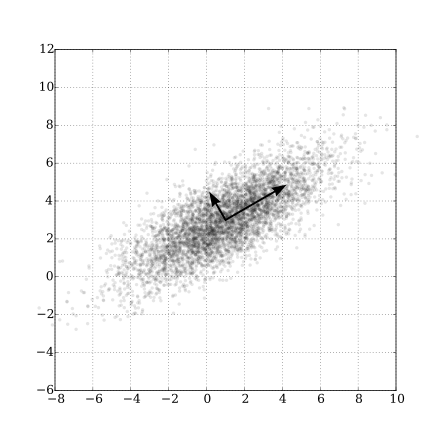

PCA is mostly used as a tool in exploratory data analysis and for making predictive models. It is often used to visualize genetic distance and relatedness between populations. PCA is either done by singular value decomposition of a design matrix or by doing the following 2 steps:

-  Calculating the data covariance (or correlation) matrix of the original data
-  Performing eigenvalue decomposition on the covariance matrix

To find the axes of the ellipsoid, we must first subtract the mean of each variable from the dataset to center the data around the origin. Then, we compute the covariance matrix of the data and calculate the eigenvalues and corresponding eigenvectors of this covariance matrix. Then we must normalize each of the orthogonal eigenvectors to become unit vectors. Once this is done, each of the mutually orthogonal, unit eigenvectors can be interpreted as an axis of the ellipsoid fitted to the data.

[Reference : https://en.wikipedia.org/wiki/Principal_component_analysis]

In [29]:
#segregate features into highly correlated and less correlated to determine the scope of PCA

cols_high_corr = ['compactness', 'circularity', 'distance_circularity', 'radius_ratio', 'scatter_ratio', 'elongatedness', 
                  'pr.axis_rectangularity', 'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1', 
                  'scaled_radius_of_gyration']

cols_less_corr = ['pr.axis_aspect_ratio', 'max.length_aspect_ratio','skewness_about', 'skewness_about.1','hollows_ratio']

#### Note : 
-   Columns *skewness_about.2* and *scaled_radius_of_gyration.1* are dropped while taking less correlated columns as they are adequately represented by *hollows_ratio* column.

In [30]:
pca = PCA(n_components=0.99, whiten=True) # Here n_components is kept as 0.99 in order to retain 99% of the variance
X_pca = pca.fit_transform(X_scaled[cols_high_corr])
print('Original number of features:', X_scaled[cols_high_corr].shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 11
Reduced number of features: 6


Percentage Variance [84.08  7.58  2.82  2.28  1.47  0.88]


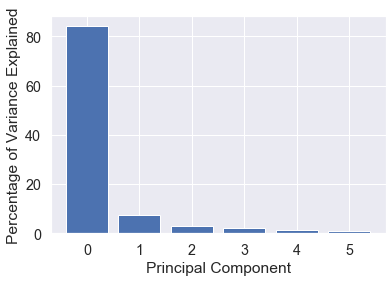

In [31]:
# PCA visualization about how the data is getting captured across different features
vehicle_pca_df = pd.DataFrame(data = X_pca)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = vehicle_pca_df.columns
plt.bar(x= range(1,7), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
print("Percentage Variance", percent_variance)
plt.show();

#### Observations :
-   As evident from above Bar Chart, first three Principal Components explain around 95% of the total data from the 11 highly correlated features.

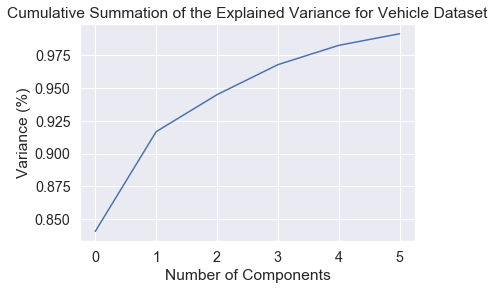

In [32]:
# Cumulative Summation of the Explained Variance plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Summation of the Explained Variance for Vehicle Dataset')
plt.show();

#### Observations :
-   Further confirmed by above plot that the first three Principal Components explain around 95% of the total data from the 11 highly correlated features.

In [33]:
# create a backup of pca dataframe before processing further
vehicle_pca_df_copy = vehicle_pca_df.copy(deep=False)
# as observed earlier, only first 3 principal components are sufficient for model training as they explain around 95% of the highly correlated columns' data
vehicle_pca_df.drop(vehicle_pca_df.columns[3:], axis=1, inplace=True)
# combining these principal components with other less correlated components to form the final dataset of independent variables for model training
vehicle_pca_df = pd.merge(vehicle_pca_df,X_scaled[cols_less_corr],right_index=True, left_index=True)
vehicle_pca_df.shape

(787, 8)

#### Observations :
-   The number of independent variables has significantly reduced <u><b>from 18 to 8</b><u>.

In [34]:
# split the data into train and test sets (70:30 ratio) before model training
X_train, X_test, y_train, y_test = train_test_split(vehicle_pca_df, y, test_size = 0.3, random_state = 10)

In [35]:
# train an SVM model on the data after doing PCA
svc_model_PCA = SVC (C =.1, kernel = "linear", gamma=1)
svc_model_PCA.fit(X_train,y_train)
prediction= svc_model_PCA.predict(X_test)
print ("Train Data Score : ",svc_model_PCA.score(X_train, y_train))
print ("Test Data Score : ",svc_model_PCA.score(X_test,y_test))
print("\n---- Confusion Matrix -----")
print (metrics.confusion_matrix(prediction,y_test))
target_names = ['bus', 'car', 'van']
print("\n---- Classification Report -----")
print(metrics.classification_report(y_test, prediction, target_names=target_names))

Train Data Score :  0.86
Test Data Score :  0.8649789029535865

---- Confusion Matrix -----
[[ 49  14   4]
 [  6 107   3]
 [  1   4  49]]

---- Classification Report -----
              precision    recall  f1-score   support

         bus       0.73      0.88      0.80        56
         car       0.92      0.86      0.89       125
         van       0.91      0.88      0.89        56

    accuracy                           0.86       237
   macro avg       0.85      0.87      0.86       237
weighted avg       0.87      0.86      0.87       237



#### Observations :
-   The <u><b>accuracy has dropped from 94% to 86%</b></u>, however, since the number of features have been reduced from 18 to 8, this can be considered as a decent accuracy score.
-   Confusion matrix indicates that
    <ol>
    <li>Out of 56 buses, 49 were identified correctly, 7 identified incorrectly.</li>
    <li>Out of 125 cars, 107 were identified correctly, 18 identified incorrectly</li>
    <li>Out of 56 vans, 49 were idenitified correctly, 7 identified incorrectly</li>
    </ol>

In [36]:
# K-fold Cross validation for above model
kfold = KFold(n_splits=50, random_state=7)
results = cross_val_score(svc_model_PCA, vehicle_pca_df, y, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.8125     0.75       0.875      0.75       0.8125     1.
 0.8125     0.9375     0.875      0.9375     0.75       0.875
 0.875      0.875      0.875      0.8125     0.8125     0.875
 1.         0.75       0.875      0.75       0.8125     0.9375
 0.875      0.875      0.9375     0.8125     0.875      0.875
 0.875      0.8125     0.8125     0.75       0.8125     0.6875
 0.8125     0.86666667 1.         0.86666667 0.8        0.93333333
 0.86666667 0.73333333 0.86666667 0.73333333 1.         0.73333333
 0.93333333 0.66666667]
Accuracy: 84.500% (8.016%)


#### Observations :
-   The <u>mean accuracy score</u> ranges between <b>76.50% - 92.50%</b> for test data if we use the reduced dataset obtained out of PCA after performing K-folds Cross Validation on the above SVM model, which is a slight dip in performance as compared to SVM model without PCA. However, considering the dimentionality reduction (18 to 8) after PCA, it can be considered a decent performance.

In [37]:
# train an SVM model on the data after doing PCA with HyperParameters using GridSearchCV

# Parameter Grid
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}] 

# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid)
 
# Train the classifier
clf_grid.fit(X_train, y_train)

print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

C:\Users\utkarsh_khamgaonkar\Documents\Personal\Research\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Parameters:
 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [38]:
# use Identified best parameters for Model Training and testing
svc_model_PCA_hyper = SVC (C =100, kernel = "rbf", gamma=0.01)
svc_model_PCA_hyper.fit(X_train,y_train)
prediction= svc_model_PCA_hyper.predict(X_test)
print ("Train Data Score : ",svc_model_PCA_hyper.score(X_train, y_train))
print ("Test Data Score : ",svc_model_PCA_hyper.score(X_test,y_test))
print("\n---- Confusion Matrix -----")
print (metrics.confusion_matrix(prediction,y_test))
target_names = ['bus', 'car', 'van']
print("\n---- Classification Report -----")
print(metrics.classification_report(y_test, prediction, target_names=target_names))

Train Data Score :  0.9581818181818181
Test Data Score :  0.9620253164556962

---- Confusion Matrix -----
[[ 56   4   2]
 [  0 120   2]
 [  0   1  52]]

---- Classification Report -----
              precision    recall  f1-score   support

         bus       0.90      1.00      0.95        56
         car       0.98      0.96      0.97       125
         van       0.98      0.93      0.95        56

    accuracy                           0.96       237
   macro avg       0.96      0.96      0.96       237
weighted avg       0.96      0.96      0.96       237



#### Observations :
-   The <u>accuracy score</u> is approx. **96%** when SVC model is used with HyperParameters using GridSearchCV, which is a huge improvement over previous SVC with PCA model's **86%** accuracy.
-   Confusion matrix indicates that
    <ol>
    <li>Out of 56 buses, all 56 were identified correctly, 0 identified incorrectly. Improvement over previous SVC with PCA model.</li>
    <li>Out of 125 cars, 120 were identified correctly, 5 identified incorrectly. Improvement over previous SVC with PCA model.</li>
    <li>Out of 56 vans, 52 were idenitified correctly, 4 identified incorrectly. Improvement over previous SVC with PCA model.</li>
    </ol>

In [39]:
# K-fold Cross validation for above model
kfold = KFold(n_splits=50, random_state=7)
results = cross_val_score(svc_model_PCA_hyper, vehicle_pca_df, y, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.9375     0.875      1.         0.9375     0.8125     1.
 1.         1.         1.         1.         1.         0.9375
 0.9375     0.9375     1.         0.75       1.         0.9375
 0.9375     0.875      1.         0.875      0.875      1.
 1.         0.9375     0.9375     0.9375     1.         0.9375
 1.         0.9375     1.         0.9375     0.8125     0.8125
 1.         0.93333333 1.         0.93333333 0.86666667 1.
 0.93333333 1.         1.         0.93333333 1.         0.86666667
 1.         0.93333333]
Accuracy: 94.550% (6.173%)


#### Observations :
-   The <u>mean accuracy score</u> ranges between <b>88.50% - 100%</b> for test data if we use the reduced dataset obtained out of PCA after performing K-folds Cross Validation on the above Hyperparameter-tuned SVM model, which is an improvement over untuned SVM with PCA model. However, it is slightly less accurate when compared with Hyperparameter-tuned SVM without PCA model.

### Final Conclusions :
-   A Hyperparameter-tuned model is more performing over corresponding untuned model.
-   The mean accuracy score obtained by performing K-folds Cross Validations technique on a model in slightly less (although very comparable), but it results in a much more stable model in Production. Hence, it is highly recommended to make it a mandatory step in the model training process.
-   There is a considerable dip in performance of a model when we perform PCA over data, and understandably so, because the result of PCA is dimentionality reduction which reduces the features to be evaluate thus making model less and less complex. At the same time, since some data is invariably thrown away in the process, hence the performance takes a slight hit. Decision to apply PCA, just like K-folds Cross Validations, is a trade-off between model complexity and overall accuracy of the system.